# Analyze effect of spiking MaxPooling implementations on accuracy

In [1]:
% matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colors = plt.cm.spectral(np.linspace(0, 0.9, 10))
colors = np.concatenate((colors, colors))


def get_order_correctness(spikerates, true_order):
    return [100 * np.mean(true_order == np.argsort(r)) for r in spikerates.transpose()]


def plot_order_correctness(spikerates_list, true_order, labels):
    for i, spikerates in enumerate(spikerates_list):
        order_acc = get_order_correctness(spikerates, true_order)
        plt.plot(order_acc, label=labels[i])
    plt.legend(loc='lower right')
    plt.title('Correctness of ordering spike-rates')
    plt.xlabel('t')
    plt.ylabel('accuracy [%]')


def plot_max_correctness(spikerates_list, activations, labels):
    for i, spikerates in enumerate(spikerates_list):
        max_acc = [100 * np.mean(np.argmax(activations) == np.argmax(r)) for r in spikerates.transpose()]
        plt.plot(max_acc, label=labels[i])
    plt.legend(loc='lower right')
    plt.title('Correctness of maximum spike-rate')
    plt.xlabel('t')
    plt.ylabel('accuracy [%]')
    plt.ylim(-1, 101)
    
    
def plot_spiketrains(spiketimes, label):
    plt.gca().set_prop_cycle(plt.cycler('color', colors))
    plt.xlabel('t')
    plt.ylabel('neuron index')
    plt.title('Spike-trains of layer {}'.format(label))
    for (neuron, spiketrain) in enumerate(spiketimes):
        spikelist = [j for j in spiketrain if j != 0]
        y = np.ones_like(spikelist) * neuron
        plt.plot(spikelist, y, '.')
        
        
def plot_spikerates(spikerates, spikerates_measured, target_activations):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    f.set_figwidth(15)
    f.set_figheight(5)
    f.suptitle('Average spike-rates of 10 neurons, with ground-truth')
    ax[0].set_xlabel('t')
    ax[1].set_xlabel('t')
    ax[0].set_ylabel('spike-rate')
    ax[0].set_prop_cycle(plt.cycler('color', plt.cm.spectral(np.linspace(0, 0.9, 10))))
    ax[1].set_prop_cycle(plt.cycler('color', plt.cm.spectral(np.linspace(0, 0.9, 10))))
    ax[0].plot(np.concatenate((spikerates.transpose(), target_activations), axis=1))
    ax[1].plot(np.concatenate((spikerates_measured, target_activations), axis=1))
    ax[0].set_title('Calculated from spikes recorded during simulation')
    ax[1].set_title('Measured directly from calculation in simulator')

## Load spike-trains and measured rates

In [4]:
path = '/home/rbodo/.snntoolbox/data/imagenet/inceptionV3/lasagne/maxpool/log/gui'
spiketrains_batch = np.load(os.path.join(path, 'avg_max', 'spiketrains', '0.npz'))['spiketrains']
print("spiketrains_batch is list of tuples: [(layer0_spiketrains, layer0_name), ...]")
print("Shape of layer_spiketrains: (batch_size, feature-maps, width, height, timesteps)")
print("E.g. first layer: {}".format(spiketrains_batch[0][0].shape))
activations_batch = np.load(os.path.join(path, 'avg_max', 'activations', '0.npz'))['activations']
spikerates_avg_measured = np.load(os.path.join(path, 'avg_max', 'debug_vars.npz'))['spikerates02']
spikerates_fir_measured = np.load(os.path.join(path, 'fir_max', 'debug_vars.npz'))['spikerates02']
spikerates_exp_measured = np.load(os.path.join(path, 'exp_max', 'debug_vars.npz'))['spikerates02']
T = spiketrains_batch[0][0].shape[-1]  # Simulation time

spiketrains_batch is list of tuples: [(layer0_spiketrains, layer0_name), ...]
Shape of layer_spiketrains: (batch_size, feature-maps, width, height, timesteps)
E.g. first layer: (1, 32, 149, 149, 200)


## Load target rates (ANN activations)

In [5]:
# Get spiketrains of first 10 neurons of first row of first feature map
# of first image of layer 02Conv preceeding 03MaxPooling
spiketrains = spiketrains_batch[2][0][0, 0, 0, :10]  # Shape: (10, 200)
spikes = np.greater(spiketrains, 0)
# Get the corresponding target activations
activations = activations_batch[2][0][0, 0, 0, :10]  # Shape: (10,)
target_activations = np.outer(np.ones(T), activations)
true_order = np.argsort(activations)

## Compute rates using measured spike-trains

### Running average across all simulation time

In [6]:
# 'avg_max'
spikerates_avg = np.cumsum(spikes, axis=1) / np.arange(1, T + 1)
# Equivalent methods:
# spikerates_avg = np.zeros_like(spiketrains)
# for t in range(T):
#     spikerates_avg[:, t] = spikerates_avg[:, t - 1] + (spikes[:, t] - spikerates_avg[:, t - 1]) / (t + 1)
#     # Or: spikerates_avg[:, t] = (spikerates_avg[:, t - 1] * t + spikes[:, t] ) / (t + 1)

### Finite-impulse-response filter

In [7]:
# 'fir_max'
spikerates_fir = np.zeros_like(spiketrains)
for t in range(T):
    spikerates_fir[:, t] = spikerates_fir[:, t - 1] + spikes[:, t] / (t + 1)

### Exponentially decaying average

In [8]:
# 'exp_max'
spikerates_exp = np.zeros_like(spiketrains)
for t in range(T):
    # spikerates_exp[:, t] = spikerates_exp[:, t - 1] + spikes[:, t] / 2. ** (t + 1)
    spikerates_exp[:, t] = spikerates_exp[:, t - 1] * 1.005 + spikes[:, t] * 0.995

### Running average with sliding window

In [9]:
from collections import deque

spikerates_run = np.zeros_like(spiketrains)
cache = deque()
n = 10  # window size
cum_sum = 0
for t in range(T):
    cache.append(spikes[:, t])
    cum_sum += spikes[:, t]
    if t < n:
        spikerates_run[:, t] = cum_sum / (t + 1)
    else:                           # if window is saturated,
        cum_sum -= cache.popleft()  # subtract oldest value
        spikerates_run[:, t] = cum_sum / n

## Plot computed spike-rates

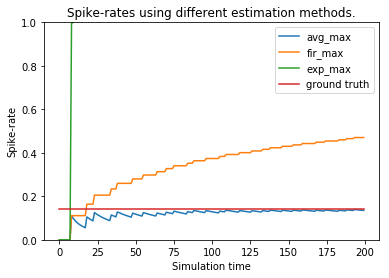

In [12]:
to_plot = [spikerates_avg[0], spikerates_fir[0], spikerates_exp[0], np.ones(T) * activations[0]]
labels = ['avg_max', 'fir_max', 'exp_max', 'ground truth']

for p, l in zip(to_plot, labels):
    plt.plot(p, label=l)
plt.ylim(0, 1)
plt.xlabel('Simulation time')
plt.ylabel('Spike-rate')
plt.title('Spike-rates using different estimation methods.')
plt.legend()

## Plot measured spike-trains

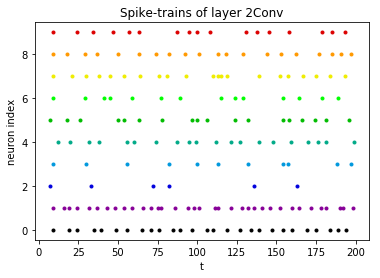

In [13]:
plot_spiketrains(spiketrains, '2Conv')

## Compare spike-rates for the different estimation techniques

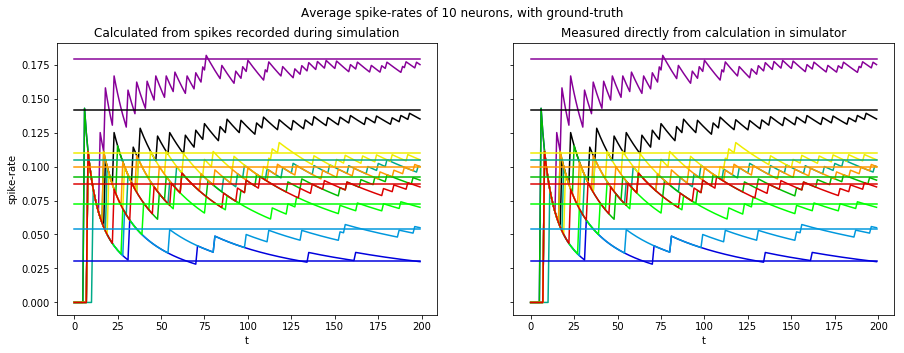

In [14]:
plot_spikerates(spikerates_avg, spikerates_avg_measured, target_activations)

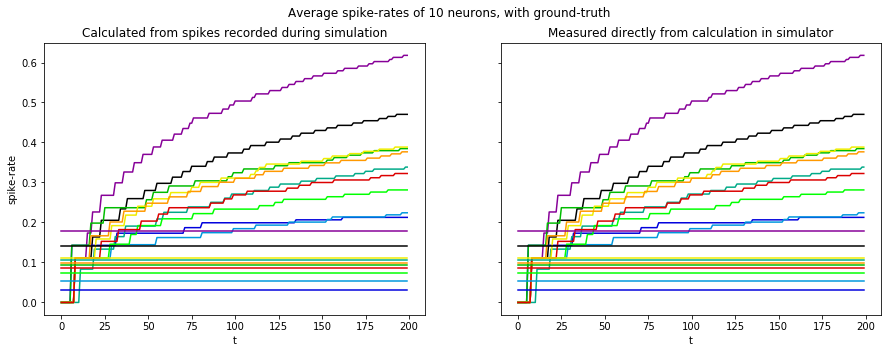

In [15]:
plot_spikerates(spikerates_fir, spikerates_fir_measured, target_activations)

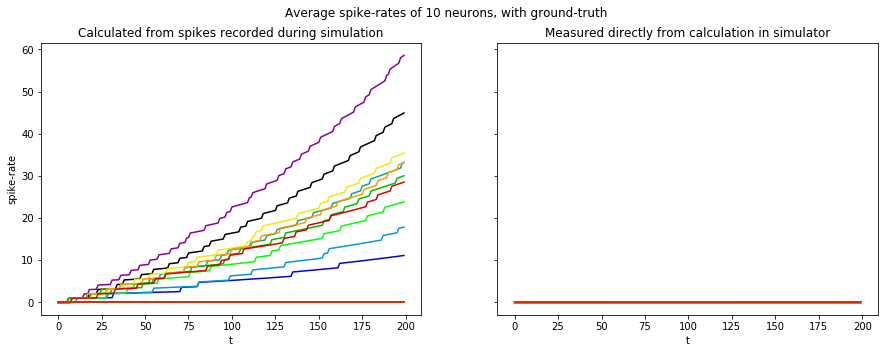

In [16]:
plot_spikerates(spikerates_exp, spikerates_exp_measured, target_activations)

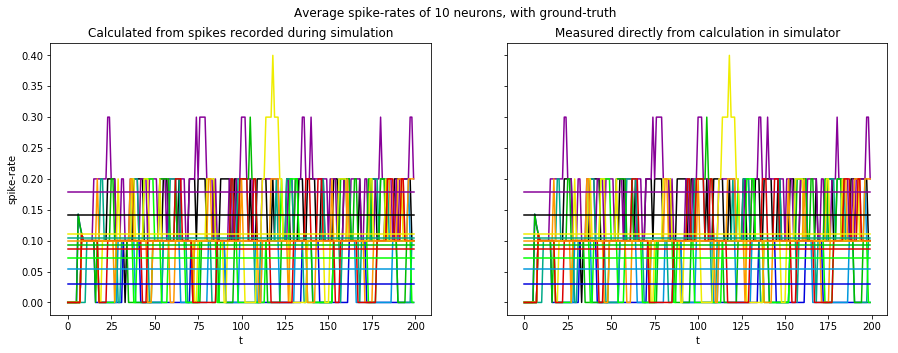

In [17]:
plot_spikerates(spikerates_run, spikerates_run.transpose(), target_activations)

The running average with sliding window does not perform well because the binary updates are large compared to the real-valued average, and cause large jumps. Increasing the window size helps, but only slightly. In the transient phase, for the duration of one window, the running average matches the standard average.

## Plot correctness of ordering the spike-rates

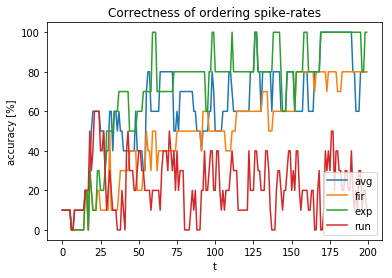

In [18]:
plot_order_correctness([spikerates_avg, spikerates_fir, spikerates_exp, spikerates_run], true_order, ['avg', 'fir', 'exp', 'run'])

What matters for the MaxPool operation is not what value the spike-rates ultimately converge to, but their ordering compared to others in the same patch. This could explain why 'fir' gives the better result, even though it does not converge to the right values. However, for the 10 neurons shown here, 'avg' in fact reaches the correct ordering faster. Note that during the first 60 time steps, all methods have at least 2 units that are wrongly ordered (each contributing 2*10% to the error). One could argue that this is not a big deal, since only the one with highest rate matters.

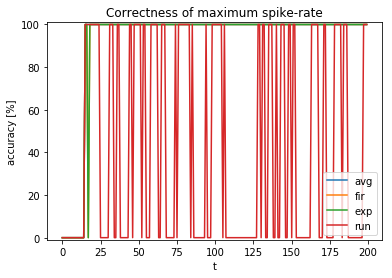

In [19]:
plot_max_correctness([spikerates_avg, spikerates_fir, spikerates_exp, spikerates_run], activations, ['avg', 'fir', 'exp', 'run'])

In this case, 'avg' and 'fir' are equally fast in determining the correct winner. However, it takes about 20 time steps, during which the gating function blocks spikes from the true winner, while the incorrectly chosen winner is not spiking. This should amount to an error of 10%. We observe much more than this.

Our previous implementation of the spiking MaxPool layer had a bug. Given the current spike input x(t) to the Pool layer coming from pre-synaptic neurons, and the previous estimate of pre-synaptic firing-rates r(t-1), the procedure is to first update the firing-rates e.g. with an online average: r(t) = r(t-1) + x(t) / t. These current rates are then used to gate the input spikes x(t) and let only the spike through that correspond to the maximum firing rate r(t) in a patch. The bug concerns the way theano updates its shared variables. The update mechanism is applied only after the calling function returns. So we were using the previous estimate r(t-1) to gate x(t). How can this have a strong effect? Imagine that neuron 0 (n0) has the second highest firing rate at time t-1, and neuron 1 (n1) has the highest: r(t-1)[0] < r(t-1)[1]. At time t, n0 fires a spike, but not n1, such that at time t, n0 should have the higher rate. However, the change is not reflected in r(t) until the function has returned, i.e. in r(t+1). So the gating function blocks the spike x(t)[0] and would have let a spike from x(t)[1] pass, but there is none. This causes the reduced rates visible in correlation plots. The solution was to store the previous input, so that at time t, r(t-1) can be used to gate spikes x(t-1). This implies that each Pooling layer introduces a delay of one time step. But even with this fix, correlation is corrupted. Interestingly, the spike-rates are now mostly higher than the target activations. This can be explained by looking at the fluctuation of the spike-rate estimates. Consider two neurons with approximately equal spike-rates. If they take turns in firing a spike, each single spike of the neuron will promote that neuron to the winner at this particular time step. This will cause the gating function to let spikes of both neurons through, whereas we would want only one of the neurons to dominate all the time, determining the output completely alone. Now we have several neurons contributing, which raises the output firing rate. A possible solution is to apply an exponential to the estimate of the firing rates to increase the distance between competing neurons and avoid oscillation of winners. This indeed helps, but an error remains because if the growth factor is chosen too high, sometimes the wrong neuron dominates, and if it is chosen too low, there remains some oscillation between winners.